In [6]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall

In [7]:
filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_new/dt.scratch/pixie3d.h5";

In [8]:
#metricpath = "/net/scratch3/giannis_kx/FTLE/11/shaped_metric_coeff6.npz";

In [9]:
na = [CartesianIndex()];

In [10]:
# read metric
#metric = npzread(metricpath);

# load covariant components
#grr = metric["grr_do"];
#gtt = metric["gtt_do"];
#grt = metric["grt_do"];
#grp = metric["grp_do"];
#gtp = metric["gtp_do"];
#gpp = metric["gpp_do"];
#Jac = metric["Jacobian"];

#radial_grid = metric["radial_grid"];
#pol_grid = metric["pol_grid"];

# radial and poloidal grid for metric interpolation
#rm = LinRange(radial_grid[1],radial_grid[end],size(radial_grid)[1]);
#um = LinRange(pol_grid[1],pol_grid[end],size(pol_grid)[1]);

# metric interpolation
#grr_int = Interpolations.interpolate(grr, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#gtt_int = Interpolations.interpolate(gtt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#grt_int = Interpolations.interpolate(grt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#grp_int = Interpolations.interpolate(grp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#gtp_int = Interpolations.interpolate(gtp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#gpp_int = Interpolations.interpolate(gpp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#Jac_int = Interpolations.interpolate(Jac, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

#grr_sint = scale(grr_int,rm,um);
#gtt_sint = scale(gtt_int,rm,um);
#grt_sint = scale(grt_int,rm,um);
#grp_sint = scale(grp_int,rm,um);
#gtp_sint = scale(gtp_int,rm,um);
#gpp_sint = scale(gpp_int,rm,um);
#Jac_sint = scale(Jac_int,rm,um);

#grr_eint = extrapolate(grr_sint,(Line(),Line()));
#gtt_eint = extrapolate(gtt_sint,(Line(),Line()));
#grt_eint = extrapolate(grt_sint,(Line(),Line()));
#grp_eint = extrapolate(grp_sint,(Line(),Line()));
#gtp_eint = extrapolate(gtp_sint,(Line(),Line()));
#gpp_eint = extrapolate(gpp_sint,(Line(),Line()));
#Jac_eint = extrapolate(Jac_sint,(Line(),Line()));

In [11]:
pxr = pyimport("pixie_read_st")
pxr.pixieload(filepath)

In [12]:
tstart = 0;
tend = 1;

In [13]:
psi = dropdims(pxr.load_array(3,4,tstart,tend),dims=4);
B1 = dropdims(pxr.load_array(1,0,tstart,tend),dims=4); # Contravariant components
B2 = dropdims(pxr.load_array(1,1,tstart,tend),dims=4);
B3 = dropdims(pxr.load_array(1,2,tstart,tend),dims=4);
B_1 = dropdims(pxr.load_array(2,0,tstart,tend),dims=4); # Covariant components
B_2 = dropdims(pxr.load_array(2,1,tstart,tend),dims=4);

In [14]:
size(psi)

(129, 65, 33)

In [15]:
#psi = -psi;

In [16]:
psit = dropdims(mean(psi,dims=3),dims=3);
B1tc = dropdims(mean(B1,dims=3),dims=3);
B2tc = dropdims(mean(B2,dims=3),dims=3);
B_1tc = dropdims(mean(B_1,dims=3),dims=3);
B_2tc = dropdims(mean(B_2,dims=3),dims=3);

In [17]:
JBpc = sqrt.((B1tc.*B_1tc) .+ (B2tc.*B_2tc));

In [18]:
# Make B-arrays into node-based quantities
# definitions of cell grid
num_r_cells = size(B3)[1];
num_u_cells = size(B3)[2];
num_phi_cells = size(B3)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);
#tn = LinRange(0, size(B3)[4]-1,size(B3)[4]);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

# Node-based grid dimensions
rdim = size(psi)[1];
udim = size(psi)[2];
fidim = size(psi)[3];
#tdim = size(psi)[4];

# Psi-magnetic angle grid dimensions
psidim = 101;
ufdim = udim; # ufdim same as udim to avoid aliasing

# Straight field line coordinate grid
pn = LinRange(0.0,1.0,psidim);
ufn = LinRange(0.0,2.0*pi,ufdim);

In [19]:
# Interpolate on cell-based grid
B1_int_cell = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B2_int_cell = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B3_int_cell = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B_1_int_cell = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B_2_int_cell = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
JBp_int_cell = Interpolations.interpolate(JBpc,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));

In [20]:
B1_sint_cell = scale(B1_int_cell,rc,uc,phic);
B2_sint_cell = scale(B2_int_cell,rc,uc,phic);
B3_sint_cell = scale(B3_int_cell,rc,uc,phic);
B_1_sint_cell = scale(B_1_int_cell,rc,uc,phic);
B_2_sint_cell = scale(B_2_int_cell,rc,uc,phic);
JBp_sint_cell = scale(JBp_int_cell,rc,uc);

In [21]:
B1_eint_cell = extrapolate(B1_sint_cell, (Line(),Periodic(),Periodic()));
B2_eint_cell = extrapolate(B2_sint_cell, (Line(),Periodic(),Periodic()));
B3_eint_cell = extrapolate(B3_sint_cell, (Line(),Periodic(),Periodic()));
B_1_eint_cell = extrapolate(B_1_sint_cell, (Line(),Periodic(),Periodic()));
B_2_eint_cell = extrapolate(B_2_sint_cell, (Line(),Periodic(),Periodic()));
JBp_eint_cell = extrapolate(JBp_sint_cell, (Line(),Periodic()));

In [22]:
# Evaluate B on node grid
B1 = B1_eint_cell(rn,un,phin);
B2 = B2_eint_cell(rn,un,phin);
B3 = B3_eint_cell(rn,un,phin);
B_1 = B_1_eint_cell(rn,un,phin);
B_2 = B_2_eint_cell(rn,un,phin);
JBpN = JBp_eint_cell(rn,un);

In [23]:
# Evaluate metric on node grid
#grr = grr_eint(rn,un); 
#gtt = gtt_eint(rn,un);
#grt = grt_eint(rn,un);
#grp = grp_eint(rn,un);
#gtp = gtp_eint(rn,un);
#gpp = gpp_eint(rn,un);
#Jac = Jac_eint(rn,un);

In [36]:
# Here do the averaged fields corresponding to the node-projected ones-otherwise, the removal of the n=0 component from the perturbation is not exact
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);
B_1t = dropdims(mean(B_1,dims=3),dims=3);
B_2t = dropdims(mean(B_2,dims=3),dims=3);

In [37]:
psi_int = Interpolations.interpolate(psi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B_1_int = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B_2_int = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B_1t_int = Interpolations.interpolate(B_1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B_2t_int = Interpolations.interpolate(B_2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
JBpN_int = Interpolations.interpolate(JBpN,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

In [38]:
# Splining Cartesian Maps
X_int = Interpolations.interpolate(pxr.X,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = Interpolations.interpolate(pxr.Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

In [39]:
psi_sint = scale(psi_int, rn,un,phin);
B3_sint = scale(B3_int, rn,un,phin);
B1_sint = scale(B1_int, rn,un,phin);
B2_sint = scale(B2_int, rn,un,phin);
B3t_sint = scale(B3t_int, rn,un);
B1t_sint = scale(B1t_int, rn,un);
B2t_sint = scale(B2t_int, rn,un);
B_1_sint = scale(B_1_int, rn,un,phin);
B_2_sint = scale(B_2_int, rn,un,phin);
B_1t_sint = scale(B_1t_int, rn,un);
B_2t_sint = scale(B_2t_int, rn,un);
JBpN_sint = scale(JBpN_int, rn,un);

X_sint = scale(X_int, rn,un,phin);
Z_sint = scale(Z_int, rn,un,phin);

In [40]:
psi_eint = extrapolate(psi_sint, (Line(),Periodic(),Periodic()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic()));
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic()));
B_1_eint = extrapolate(B_1_sint, (Line(),Periodic(),Periodic()));
B_2_eint = extrapolate(B_2_sint, (Line(),Periodic(),Periodic()));
B_1t_eint = extrapolate(B_1t_sint, (Line(),Periodic()));
B_2t_eint = extrapolate(B_2t_sint, (Line(),Periodic()));
JBpN_eint = extrapolate(JBpN_sint, (Line(),Periodic()));

X_eint = extrapolate(X_sint, (Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint, (Line(),Periodic(),Periodic()));

In [31]:
# Preparations of the Python module
pxr.Axes_of_Interpolation(B3)
pxr.Grid_Interpolations(psit,B1,B2,B3)
pxr.Calculation_of_Units_and_Sizes()

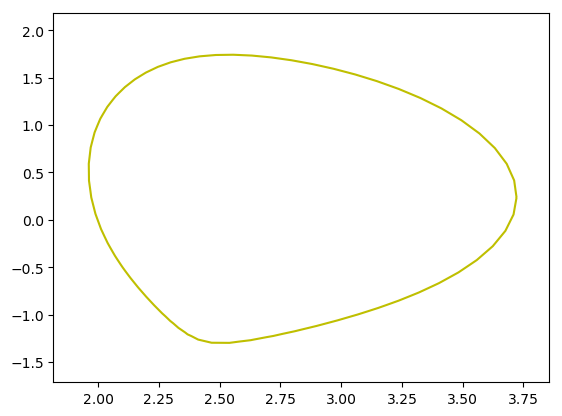

In [34]:
psi_min,norm = pxr.Normalization_numbers(psit,B1t,B2t);
pythonresult = pxr.create_r_psi_list(psit,B1t,B2t);
r_of_psi_array = pythonresult[1]; # Pick python outputs
rmaxis = pythonresult[2];
umaxis = pythonresult[3];

## Divergence Cleanup

In [41]:
include("DivClean.jl")

Main.DivClean

In [43]:
using .DivClean

In [44]:
GAu = DivClean.grid_Au(B3_eint,rmaxis[1],umaxis[1],rn,un,phin);
GAp = DivClean.grid_Aphi(B1_eint,B2_eint,rmaxis[1],umaxis[1],rn,un,phin);

In [45]:
# Spline Vector Potential
GAu = Float64.(GAu);
GAp = Float64.(GAp);

GAu_int = Interpolations.interpolate(GAu,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
GAp_int = Interpolations.interpolate(GAp,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

GAu_sint = scale(GAu_int,rn,un,phin);
GAp_sint = scale(GAp_int,rn,un,phin);

GAu_eint = extrapolate(GAu_sint, (Line(),Periodic(),Periodic()));
GAp_eint = extrapolate(GAp_sint, (Line(),Periodic(),Periodic()));

In [46]:
function B1_df(r,u,phi)
    return Interpolations.gradient(GAp_eint,r,u,phi)[2]
end

function B2_df(r,u,phi)
    return -Interpolations.gradient(GAp_eint,r,u,phi)[1]
end

function B3_df(r,u,phi)
    return Interpolations.gradient(GAu_eint,r,u,phi)[1] 
end

B3_df (generic function with 1 method)

In [66]:
B3_df(0.33,0,0)

0.6381500204909303

In [47]:
#B_1tg = grr.*B1t .+ grt.*B2t .+ grp.*B3t;
#B_2tg = grt.*B1t .+ gtt.*B2t .+ gtp.*B3t;
#B_3tg = grp.*B1t .+ gtp.*B2t .+ gpp.*B3t;

In [48]:
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B_2tg[:,:])
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B_2t[:,:,1],color="k")
#PyPlot.show()

In [156]:
function Flux_surface!(du,u,p,t)
    #du[1] = B1t_eint(u[1],u[2],p[1])/JBpN_eint(u[1],u[2],p[1]) # use of n=o components          
    #du[2] = B2t_eint(u[1],u[2],p[1])/JBpN_eint(u[1],u[2],p[1])
    #du[3] = B3t_eint(u[1],u[2],p[1])/JBpN_eint(u[1],u[2],p[1])
    du[1] = B1_df(u[1],u[2],0)/JBpN_eint(u[1],u[2]) # use of n=o components and divergence cleaned fields         
    du[2] = B2_df(u[1],u[2],0)/JBpN_eint(u[1],u[2])
    du[3] = B3_df(u[1],u[2],0)/JBpN_eint(u[1],u[2])
    end

function condition(u,t,integrator)
    abs(u[2]) - 2*pi 
end

function condition_zero(u,t,integrator)
    u[2] - 0.0
end

function condition_crossing(u,t,integrator)
    integrator.p[2] == 2.0
end 

function affect_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end


function affect!(integrator)
    terminate!(integrator)
end

cb1 = ContinuousCallback(condition,affect!,rootfind = true)
cb2 = ContinuousCallback(condition_zero,affect_cross!,rootfind = true)
cb3 = DiscreteCallback(condition_crossing,affect!)

function fs_integration(rs::Float64,us::Float64,time::Int)
    u0 = [rs,us,0.0]
    p = [time,0]
    tspan = (0.0,180.0)
    prob = ODEProblem(Flux_surface!,u0,tspan,p)
    cbs = CallbackSet(cb1,cb2,cb3)
    integrator = init(prob,DP8(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,DP8(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    return sol
end

fs_integration (generic function with 1 method)

In [53]:
# dB calculation
#dB1 = B1.-B1t[:,:,na];
#dB2 = B2.-B2t[:,:,na];    
#dB3 = B3.-B3t[:,:,na];

# b-hat-rho in r,theta,phi
#brho = dB1.*B2t[:,:,na] .- dB2.*B1t[:,:,na];
#b_hat_rho = brho./B3t[:,:,na];

# Interpolate b_hat_rho avoiding problematic r=0 point
#b_hat_rho_int = Interpolations.interpolate(b_hat_rho[2:end,:,:,:],(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
#b_hat_rho_sint = scale(b_hat_rho_int, rn[2:end],un,phin,tn);
#b_hat_rho_eint = extrapolate(b_hat_rho_sint, (Line(),Periodic(),Periodic(),Line()));

In [312]:
using FFTW

In [370]:
fB1 = fft(B1,[2,3]);
fB2 = fft(B2,[2,3]);
fB3 = fft(B3,[2,3]);

In [340]:
fdb1 = fft(dB1,[2,3]);
fdb2 = fft(dB2,[2,3]);
fdb3 = fft(dB3,[2,3]);
fbhat = fft(b_hat_rho,[2,3]);

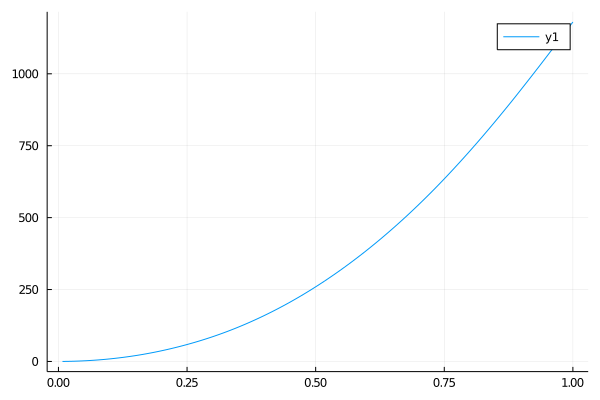

In [386]:
Plots.plot(rn[2:end],abs.(fB3[2:end,2,1,1]))

## First Flux surface

In [157]:
rprob = r_of_psi_array[1][4]

0.3197433238931999

In [158]:
sol = fs_integration(rprob,0.0,0);

In [159]:
X_ffs = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
Z_ffs = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];

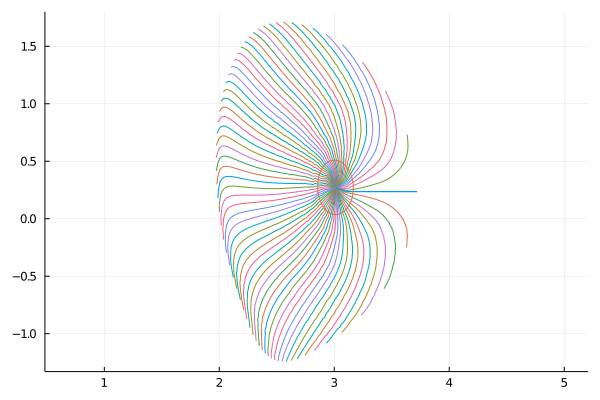

In [160]:
Plots.plot!(X_ffs,Z_ffs)

In [161]:
Xma = X_eint(rmaxis[1],umaxis[1],0);
Zma = Z_eint(rmaxis[1],umaxis[1],0);
uf_list = []
X_list = Xma.*ones(size(pxr.X)[2]*size(pxr.X)[3])
Z_list = Zma.*ones(size(pxr.X)[2]*size(pxr.X)[3])
r_list = []
u_list = []
q_list = []
icount = 0
for r in r_of_psi_array[1][2:95]
    #icount = icount+1
    #print("i:",icount,"\n")
#for r in r_of_PsiT_values[:]
#for r in RS
    sol = fs_integration(r,0.0,0)
    uf_sol = sol[3,:]
    q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
    append!(q_list,q_redef)
    uf_rsc = uf_sol/q_redef
    l = sol.t
    l_of_uf_rsc = Spline1D(sort!(uf_rsc[2:end-2]),l[2:end-2],bc="extrapolate",s=1e-6)
    #println("luf")
    ls = l_of_uf_rsc(ufn)
    u_of_l = Spline1D(sort!(l[2:end-2]),sol[2,2:end-2],bc="extrapolate",s=1e-6)
    #println("ul")
    r_of_l = Spline1D(sort!(l[2:end-2]),sol[1,2:end-2],bc="extrapolate",s=1e-3)
    #println("rl")
    l_grid = l_of_uf_rsc(un)
    for i in 1:length(l_grid)
        rg = r_of_l(l_grid[i])
        ug = u_of_l(l_grid[i])
        for pg in phin
            Xg = X_eint(rg,ug,pg)
            Zg = Z_eint(rg,ug,pg)
            append!(X_list,Xg)
            append!(Z_list,Zg)
        end
        append!(r_list,rg)
        append!(u_list,ug)
    end
end

In [162]:
X_arr = permutedims(reshape(X_list,size(pxr.X)[3],size(pxr.X)[2],95),(3,2,1));
Z_arr = permutedims(reshape(Z_list,size(pxr.X)[3],size(pxr.X)[2],95),(3,2,1));

In [179]:
Plots.plot()
for i in 1:2:65
    #Plots.plot!(X_arr[1:end,i,17],Z_arr[1:end,i,17],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,6],Z_arr[1:end,i,6],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,7],Z_arr[1:end,i,7],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,8],Z_arr[1:end,i,8],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,10],Z_arr[1:end,i,10],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,5],Z_arr[1:end,i,5],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,9],Z_arr[1:end,i,9],legend=false,aspect_ratio=:equal)
    #Plots.plot!(X_arr[1:end,i,13],Z_arr[1:end,i,13],legend=false,aspect_ratio=:equal)
    Plots.plot!(X_arr[1:end,i,1],Z_arr[1:end,i,1],legend=false,aspect_ratio=:equal)
end

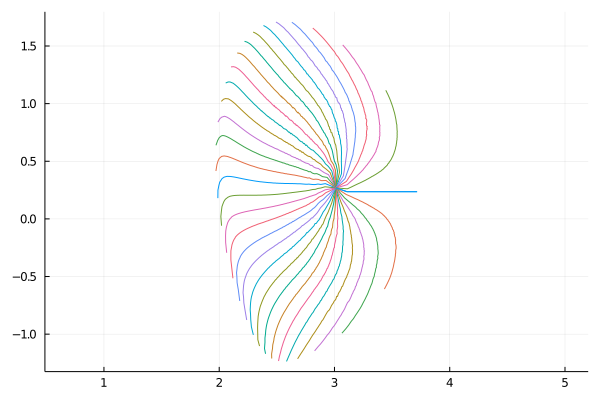

In [180]:
current()

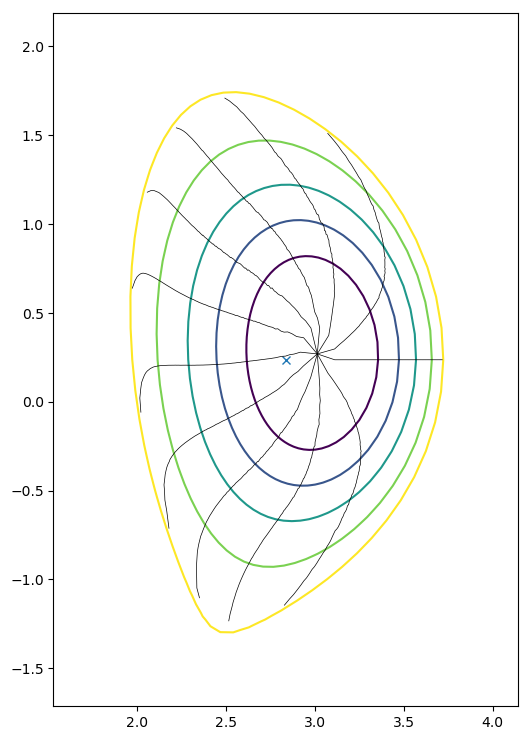

In [170]:
PyPlot.figure(figsize=(6,9))
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],(psi[:,:,1,1].- psi_min[1])./(norm[1].-psi_min[1]),levels=[0.2,0.4,0.6,0.8,0.95])
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"x")
#PyPlot.plot(Xma,Zma,"s")
#PyPlot.plot(X_ffs,Z_ffs,linestyle="--")
for i in 1:6:65
    PyPlot.plot(X_arr[1:end,i,1],Z_arr[1:end,i,1],"k",linewidth=0.5)
    PyPlot.axis("equal")
end
#PyPlot.xlim(2.8,3.1)
#PyPlot.ylim(0.2,0.4)
PyPlot.show()

## Interpolate and re-grid

In [219]:
X_Aint = Interpolations.interpolate(X_arr,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_Aint = Interpolations.interpolate(Z_arr,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

In [220]:
X_sAint = scale(X_Aint,pn[1:95],un);
Z_sAint = scale(Z_Aint,pn[1:95],un);

In [221]:
X_eAint = extrapolate(X_sAint,(Line(),Periodic()));
Z_eAint = extrapolate(Z_sAint,(Line(),Periodic()));

In [222]:
# Finer grid
pfg = LinRange(0.0,1.0,500);

In [223]:
X_Arrfg = X_eAint(pfg,un);
Z_Arrfg = Z_eAint(pfg,un);

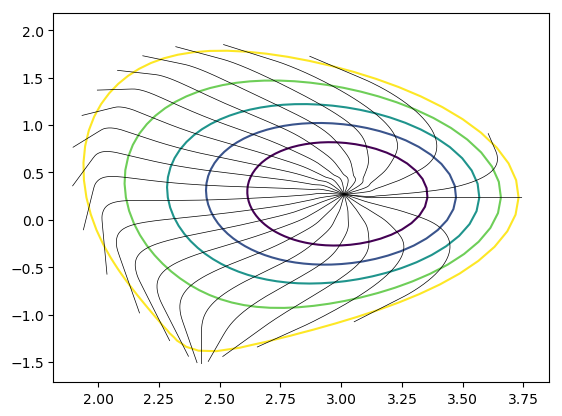

In [225]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],(psi[:,:,1,1].- psi_min[1])./(norm[1].-psi_min[1]),levels=[0.2,0.4,0.6,0.8,0.97])
for i in 1:3:65
    PyPlot.plot(X_Arrfg[1:end,i],Z_Arrfg[1:end,i],"k",linewidth=0.5)
    #PyPlot.axis("equal")
end
PyPlot.show()

In [57]:
Xn = LinRange(minimum(pxr.X[:,:,1]),maximum(pxr.X[:,:,1]),100);
Zn = LinRange(minimum(pxr.Z[:,:,1]),maximum(pxr.Z[:,:,1]),100);

## Center coordinate system on magnetic axis

In [231]:
rs = [i/(size(pxr.X)[1]-1) for i in 0:size(pxr.X)[1]-1];
us = [(2*pi)*i/(size(pxr.X)[2]-1) for i in 0:size(pxr.X)[2]-1];

In [155]:
Xma = X_eint(rmaxis[1],umaxis[1],0);
Zma = Z_eint(rmaxis[1],umaxis[1],0);

In [ ]:
X_cent = []
Z_cent = []
for i in 1:size(pxr.X)[1]
    for j in 1:size(pxr.X)[2]
        #x = X_eint(rs[i]-rmaxis[1],us[j]-umaxis[1],0)
        #z = Z_eint(rs[i]-rmaxis[1],us[j]-umaxis[1],0)
        x = pxr.X[i,j,1]-Xma;
        z = pxr.Z[i,j,1]-Zma;
        append!(X_cent,x)
        append!(Z_cent,z)
    end
end
X_cent = permutedims(reshape(X_cent,size(pxr.X)[2],size(pxr.X)[1]),(2,1));
Z_cent = permutedims(reshape(Z_cent,size(pxr.X)[2],size(pxr.X)[1]),(2,1));

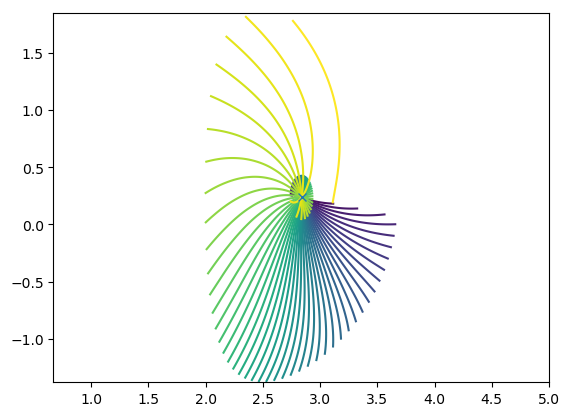

In [200]:
PyPlot.contour(X_cent[10:end,:],Z_cent[10:end,:],ufarr2,60)
#PyPlot.contour(X_cent[:,:],Z_cent[:,:],psi[:,:,1,1])
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"x")
PyPlot.axis("equal")
PyPlot.show()

In [156]:
Xma

3.0126267583964452

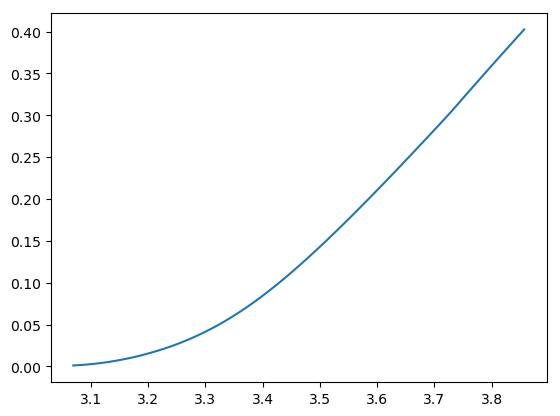

In [241]:
PyPlot.plot(pxr.X[30:end,1,1],psi[30:end,1,1,1].-psi_min[1])
PyPlot.show()

In [252]:
P_values = (psi_eint(r_of_psi_array[1,:],0,0,0).-psi_min[1])./(norm[1].-psi_min[1]);

In [254]:
PT_values = P_values[2:95].*q_list;

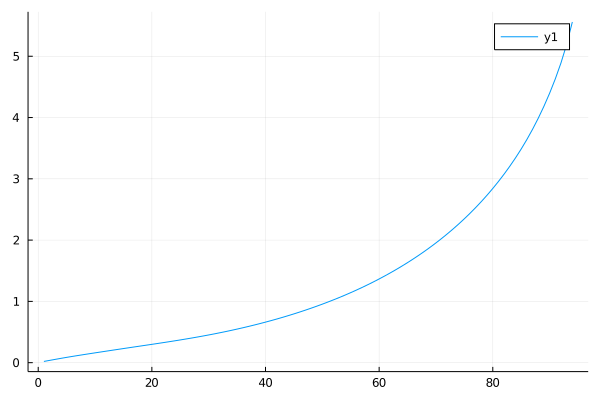

In [269]:
Plots.plot(PT_values)

In [248]:
Pplus = circshift(P_values,+1);
dP = P_values-Pplus;

In [255]:
PTplus = circshift(PT_values,+1);
dPT = PT_values-PTplus;

In [256]:
dPT

94-element Array{Float64,1}:
 -5.538688175701937
  0.016887354066108275
  0.016783217696141557
  0.01659728091388095
  0.016081369077807814
  0.015422522395370397
  0.01492368089624696
  0.014578506737207328
  0.014380668952024583
  0.014238244392421717
  0.014141293486462175
  0.014097797463285183
  0.014044645054098304
  ⋮
  0.12795816913222913
  0.135834295944802
  0.14476479496764005
  0.15499704032797768
  0.16673087860327218
  0.18012954506057532
  0.19535143183371195
  0.21275391986299041
  0.23363044178949455
  0.26094973874779903
  0.30162397756074544
  0.3663149762967226

In [284]:
r_of_PsiT = Spline1D(PT_values,r_of_psi_array[1,2:95],bc="extrapolate",s=1e-8);

In [274]:
pTn = LinRange(minimum(PT_values),maximum(PT_values),100);

In [283]:
PsiT_of_r = Spline1D(r_of_psi_array[1,2:95],PT_values,bc="extrapolate",s=1e-8);

In [275]:
r_of_PsiT_values = r_of_PsiT(pTn);

In [276]:
r_of_PsiT_values

100-element Array{Float64,1}:
 0.2638642038675533
 0.3454941462174628
 0.39892630913371624
 0.441354070431523
 0.47641468684447086
 0.5068313600166113
 0.5329541629104217
 0.5549951315309456
 0.5736214785182057
 0.589674174163236
 0.6037340281536859
 0.6162831795606355
 0.6276192464442168
 ⋮
 0.8546483979557502
 0.8554548285301334
 0.8562377880672667
 0.8569975051747507
 0.8577342084601856
 0.8584481265311716
 0.8591394879953085
 0.8598085214601969
 0.8604554555334368
 0.8610805188226283
 0.8616839399353717
 0.8622659474792671

In [271]:
(psi_eint(0.5265857216680526,0,0,0).-psi_min[1])./(norm[1].-psi_min[1])

0.2298021990971957

In [286]:
PsiT_val = PsiT_of_r(r_of_PsiT_values);

In [287]:
PsiT_val_plus = circshift(PsiT_val,+1);
dPsiT = PsiT_val.-PsiT_val_plus

100-element Array{Float64,1}:
 -5.539121376083429
  0.055933636424560215
  0.05596759374215049
  0.055942537515831725
  0.055926026097864734
  0.05596681520763508
  0.055921313033297615
  0.05597764007009304
  0.055915457112211076
  0.05597682337703108
  0.05590397182151696
  0.0559786119068435
  0.055972179330812
  ⋮
  0.055659127326406654
  0.05570519131287366
  0.05580442427303556
  0.05593170890262833
  0.05606454998024102
  0.05618292686717741
  0.056269145932707154
  0.05630769842470951
  0.05628512366578864
  0.056189877458614035
  0.05601220558301723
  0.05574402227000608

The result is the same even when we do a second pass and integrate on $d\Psi_{tor} = const$

In [167]:
pn

101-element LinRange{Float64}:
 0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,…,0.94,0.95,0.96,0.97,0.98,0.99,1.0

In [168]:
pn[88]

0.87

In [169]:
round(pn[88],digits=2)

0.87